## Week 7: Antechamber Tutorial

### Tutorial 1: Simulating a pharmaceutical compound using antechamber (molecular input file processor) and the Generalized Amber Force Field
#### http://ambermd.org/tutorials/basic/tutorial4b

In [ ]:
# Target disease: human immunodeficiency virus type 1 (HIV-1)
# Drug name: Sustiva (Efavirenz)
# Function: reverse transcriptase (RT) inhibitor
# Company: Bristol-Myers Squibb 

In [ ]:
# Use the Antechamber tools with LEaP to create topology and coordinate files for the prescription drug Sustiva (Efavirenz)

$ module load amber/openmpi/intel/22.03

In [ ]:
# treating the molecule using the GAFF force field
# using ff99SB force field

### Part 0: Create parameter and coordinate files for the compound

In [ ]:
# Get the structue
$ wget https://ambermd.org/tutorials/basic/tutorial4b/files/sustiva.pdb

In [ ]:
# run 'reduce' to add all the hydrogen atoms to the pdb file
$ reduce sustiva.pdb > sustiva_h.pdb 

In [ ]:
# change the name of the residue from "EFZ" to "SUS" (consistent with the name of pdb)

$ wget https://ambermd.org/tutorials/basic/tutorial4b/files/sustiva_new.pdb

In [ ]:
# create the "mol2" file, required to define a new unit in LEaP
# sustiva.mol2 file contains the definition of compound residue including all of the charges and atom types that we will load into LEaP to when creating our prmtop and rst7 files.

# -i sustiva_new.pdb: input file
# -fi pdb: antechamber that this is a pdb format file
# -o sustiva.mol2: output file
# -fo mol2: output file to be of Tripos Mol2 format
# -c bcc: use the AM1-BCC charge model in order to calculate the atomic point charges
# -s 2: defines the verbosity of the status information provided by antechamber. 

$ antechamber -i sustiva_new.pdb -fi pdb -o sustiva.mol2 -fo mol2 -c bcc -s 2

In [ ]:
# All of the GAFF atom types are in lower case (eg.sustiva.mol2)
# This is the mechanism by which the GAFF force field is kept independent of the macromolecular AMBER force fields. 
# All of the traditional AMBER force fields use uppercase atom types.

In [ ]:
# utility parmchk2 to test if all the parameters we require are available
# sustiva.frcmod is a parameter file that can be loaded into LEaP in order to add missing parameters.

$ parmchk2 -i sustiva.mol2 -f mol2 -o sustiva.frcmod

# MISSING ANGLE PARAMETERS!

In [ ]:
# load sustiva as a unit in LEaP
# run tleap and ensure the GAFF force field is available

$ tleap -f oldff/leaprc.ff99SB

In [ ]:
# Loading parameters: /ext3/apps/amber/22.03/openmpi/intel/dat/leap/parm/gaff.dat

$ source leaprc.gaff

In [ ]:
# load our sustiva unit (sustiva.mol2): 

$ SUS = loadmol2 sustiva.mol2 

In [ ]:
$ list

#ACE       ALA       ARG       ASH       ASN       ASP       CALA      CARG      
# CASN      CASP      CCYS      CCYX      CGLN      CGLU      CGLY      CHCL3BOX  
# CHID      CHIE      CHIP      CHIS      CILE      CIO       CLEU      CLYS      

In [ ]:
$ check SUS

# Checking 'SUS'....
# Checking parameters for unit 'SUS'.
# Checking for bond parameters.
# Checking for angle parameters.
# Unit is OK. ????                                                            

In [ ]:
$ loadamberparams sustiva.frcmod

# Loading parameters: ./sustiva.frcmod
# Reading force field modification type file (frcmod)
# Reading title:
# Remark line goes here ????

In [ ]:
# create the library file for compounds (sus.lib)

$ saveoff SUS sus.lib 

# Creating sus.lib
# Building topology.
# Building atom parameters.

In [ ]:
# create the prmtop and rst7 files for compounds (sus.lib)

$ saveamberparm SUS sustiva.prmtop sustiva.rst7

### Part 1: Creating topology and coordinate files for Compound-RT complex

In [ ]:
# Download truncated protein-ligand complex pdb

$ wget https://ambermd.org/tutorials/basic/tutorial4b/files/1FKO_trunc.pdb

In [ ]:
# Download truncated protein-ligand complex pdb with edited residue name 'SUS'

$ wget https://ambermd.org/tutorials/basic/tutorial4b/files/1FKO_trunc_sus.pdb

In [ ]:
#  start tleap 

$ tleap -f oldff/leaprc.ff99SB

In [ ]:
$ source leaprc.gaff 

In [ ]:
$ loadamberparams sustiva.frcmod

In [ ]:
$ loadoff sus.lib 

In [ ]:
$ complex = loadpdb 1FKO_trunc_sus.pdb   

In [ ]:
$ saveamberparm complex 1FKO_sus.prmtop 1FKO_sus.rst7

In [ ]:
$ savepdb complex 1FKO_sus.pdb

In [ ]:
$ quit

In [ ]:
$ tleap -f tleap2.in

### Minimize and Equilibrate the Sustiva-RT complex

In [ ]:
# Minimize our complex to remove any possible bad contacts
# Do a total of 200 steps of minimization (MAXCYC) with the first 50 being steepest descent (NCYC), the remainder will be conjugate gradient (MAXCYC-NCYC).

$ wget https://ambermd.org/tutorials/basic/tutorial4b/files/min.in

In [ ]:
# run the minimization

$ sander -O -i min.in -o 1FKO_sus_min.out -p 1FKO_sus.prmtop -c 1FKO_sus.rst7  -r 1FKO_sus_min.ncrst  &

In [ ]:
# run MD (imin=0)
# not a restart (irest=0).
# time step of 1 fs 
# run for 1000 steps [2 ps] (dt = 0.001, nstlim=1000, ntc=1).
# write to our output file every 20 steps and to our trajectory [mdcrd] file every 20 steps (ntpr=20,ntwx=20). 
# Temperature control: use a Langevin dynamics approach with a collision frequency of 1 ps^-1. 
# start our system at 0K and target temperature of 300K (ntt=3, gamma_ln=1.0, tempi=0.0, temp0=300.0).

$ wget https://ambermd.org/tutorials/basic/tutorial4b/files/eq.in

In [ ]:
sander -O -i eq.in -o 1FKO_sus_eq.out -p 1FKO_sus.prmtop -c 1FKO_sus_min.ncrst  -r 1FKO_sus_eq.rst -x 1FKO_sus_eq.nc &

In [ ]:
# Now that the sustiva-RT complex is minimized and heated, you can take a look at the snapshot at 300K.
# This structure can be used as the starting point for further equilibration.

### Tutorial 2: Simulating the Green Fluorescent Protein and Building a Modified Amino Acid Residue
#### https://ambermd.org/tutorials/basic/tutorial5/

#### Part 0: Preparing the PDB file

In [ ]:
$ module load amber/openmpi/intel/22.03

In [ ]:
# Download pdb file
# contains the GFP with a fluorophore named CRO

$ wget https://ambermd.org/tutorials/basic/tutorial5/files/1EMA.pdb

In [ ]:
# Amber includes a script called pdb4amber that will modify the PDB file for use with tleap

$ pdb4amber -i 1EMA.pdb -o gfp.pdb --dry --reduce

In [ ]:
# PDB file should now contain all of the hydrogens for each of the residues, and no disulfide bonds
# We need to manually edit the gfp.pdb file
# replace of MSE(selenomethionine) with MET(methionine)
# change the element from SE(selenium atom) to S(sulfur atom)
# Wget the edited pdb file

$ wget https://ambermd.org/tutorials/basic/tutorial5/files/gfp.pdb

#### Section 2: Computing partial charges and atom types for the custom residue (CRO)

In [ ]:
# Since CRO is not a standard residue (a cyclization of three amino acid)
# We need to deriving charges and determining the atom types of the CRO residue
# Method: use antechamber to derive charges using the bcc charge scheme 

In [ ]:
# Download the CRO component definition file in CIF format, CRO.cif
# Chemical Component Dictionary (CCD) that contains observed and idealized structures for all residue and small molecule components that appear in any PDB entry

wget https://ambermd.org/tutorials/basic/tutorial5/files/CRO.cif

In [ ]:
# The antechamber program can read the component CIF (ccif) files and generate charges and atom types.
# -at amber:ask for Amber atom types

$ antechamber -fi ccif -i CRO.cif -bk CRO -fo ac -o cro.ac -c bcc -at amber

In [ ]:
# antechamber is mostly set up to use gaff atom types, so it occasionally makes a mistake with the Amber atom types
# So, we need to fix up the beginning N atom, which should have the same type as an amide nitrogen (N)
# Download the fixed file

$ wget https://ambermd.org/tutorials/basic/tutorial5/files/cro.ac

# We now have the partial atomic charges and atom types for the atoms within the antechamber molecule file.

#### Section 3: Preparing the residue library and force field parameters for use with LEaP

In [ ]:
# we need to strip off the atoms at the beginning and the end to make an "amino acid"-like residue that is ready to be connected to other amino acids at its N- and C-termini
# This can be done using the prepgen program with an "mc" (mainchain) file that identifies the atoms to be removed as well as which atoms are part of the main chain (i.e., backbone atoms).
# Make a cro.mc file

    """
HEAD_NAME N1
TAIL_NAME C3
MAIN_CHAIN CA1
MAIN_CHAIN C1
MAIN_CHAIN N3
MAIN_CHAIN CA3
OMIT_NAME H2
OMIT_NAME HN11
OMIT_NAME OXT
OMIT_NAME HXT
PRE_HEAD_TYPE C
POST_TAIL_TYPE N
CHARGE 0.0
    """

In [ ]:
# runs prepgen to strip out the unneeded atoms at the N- and C-termini

$ prepgen -i cro.ac -o cro.prepin -m cro.mc -rn CRO

In [ ]:
# Next, check the covalent parameters (bonds, angles, and dihedrals) are available
# The parmchk2 program figures out what parameters will be needed and checks to see if they are in the standard files

# BUT!!

# $ parmchk2 -i cro.prepin -f prepi -o frcmod.cro -a Y \
#          -p $AMBERHOME/dat/leap/parm/parm10.dat
# Cannot open file /share/apps/amber/22.03/openmpi/intel/dat/leap/parm/parm10.dat in readparm(), exit

In [ ]:
$ env | grep AMBER

# AMBER_ROOT=/share/apps/amber/22.03/openmpi/intel
# LMOD_FAMILY_AMBER=amber/openmpi/intel
# LMOD_FAMILY_AMBER_VERSION=22.03
# AMBER_HOME=/share/apps/amber/22.03/openmpi/intel

# CAN'T FIND THE parm10.dat FILE!

In [ ]:
# Download the parm10.dat file manually 
# From https://github.com/choderalab/ambermini/blob/master/share/amber/dat/leap/parm/parm10.dat

# parmchk2 -i cro.prepin -f prepi -o frcmod.cro -a Y \
#          -p ./parm10.dat

In [ ]:
$ module avail

# amber/openmpi/intel/20.06
# amber/openmpi/intel/20.11                      
# amber/openmpi/intel/22.00                     
# amber/openmpi/intel/22.03

In [ ]:
$ module swap amber/openmpi/intel/22.03 amber/openmpi/intel/20.06

In [ ]:
# Find the parm10.dat file using other versions of AMBER!!
# parm10.dat file is the main parameter database for the ff14SB force field

$ parmchk2 -i cro.prepin -f prepi -o frcmod.cro -a Y \
         -p $AMBERHOME/dat/leap/parm/parm10.dat

In [ ]:
# In the output file: frcmod.cro
# ATTN, need revision: This means that parmchk2 could not find suitably similar parameters in the parm10.dat database
# There are also numerous other parameters that were selected having a high penalty (which indicates a poor fit as determined by parmchk2
# A simple solution that is likely to yield sensible parameters is to request that parmchk2 searches through gaff.dat to "fill in" the parameters by the options in parm10.dat.
# To do this, we will delete the parameters that say "ATTN, need revision"

$ grep -v "ATTN" frcmod.cro > frcmod1.cro

In [ ]:
# parmchk2 searches through gaff.dat to extract gaff atom types

$ parmchk2 -i cro.prepin -f prepi -o frcmod2.cro

#### Section 4: Creating the topology and coordinate files for simulation

In [ ]:
# We now have all of the files we need to create the topology and coordinate files for sander or pmemd! 
# We just need to load these files into LEaP to create these files.

# Make a tleap.in file 
# load frcmod2.cro first, followed by frcmod1.cro to make sure that all of the gaff parameters are overwritten

    """
source leaprc.protein.ff14SB
set default PBRadii mbondi3
loadAmberPrep cro.prepin
loadAmberParams frcmod2.cro
loadAmberParams frcmod1.cro
x = loadPDB gfp.pdb
saveAmberParm x gfp.parm7 gfp.rst7
quit
    """


In [ ]:
$ tleap -f tleap.in

#### Section 5: Simulations; minimization, heating, equilibration, and production

#### Minimization

In [ ]:
# Make a min.in file
# igb=8 implicit solvent model


    """
simple generalized Born minimization script
 &cntrl
   imin=1, ntb=0, maxcyc=100, ntpr=10, cut=1000., igb=8, 
 /
    """


In [ ]:
$ sander -O -i min.in -p gfp.parm7 -c gfp.rst7 -o min1.out -r min1.rst7

#### Heating

In [ ]:
# Make a heat.in file

    """
Implicit solvent initial heating mdin
 &cntrl
   imin=0, irest=0, ntx=1,
   ntpr=1000, ntwx=1000, nstlim=100000,
   dt=0.002, ntt=3, tempi=10,
   temp0=300, gamma_ln=1.0, ig=-1,
   ntp=0, ntc=2, ntf=2, cut=1000,
   ntb=0, igb=8, ioutfm=1, nmropt=1,
 /
 &wt
   TYPE='TEMP0', ISTEP1=1, ISTEP2=100000,
   VALUE1=10.0, VALUE2=300.0,
 /
 &wt TYPE='END' /
    """


In [ ]:
sander -O -i heat.in -p gfp.parm7 -c min1.rst7 -o heat.mdout \
       -x heat.nc -r heat.rst7

#### Production simulation

In [ ]:
# Make a md.in file

"""
Implicit solvent molecular dynamics
 &cntrl
   imin=0, irest=1, ntx=5,
   ntpr=1000, ntwx=1000, nstlim=500000,
   dt=0.002, ntt=3, tempi=300,
   temp0=300, gamma_ln=1.0, ig=-1,
   ntp=0, ntc=2, ntf=2, cut=1000,
   ntb=0, igb=8, ioutfm=1,
 /
"""

In [ ]:
$ sander -O -i md.in -p gfp.parm7 -c heat.rst7 -o md1.mdout \
       -x md1.nc -r md1.rst7

#### Section 6: Data analysis

In [ ]:
# Make a min folder
$ process_minout.perl ../min1.out

    Time    Energy
0      1  441120.0
1     10  113210.0
2     20   -5426.1
3     30   -6561.8
4     40   -7078.1
5     50   -7322.2
6     60   -7371.0
7     70   -7454.8
8     80   -7489.0
9     90   -7535.2
10   100   -7571.8


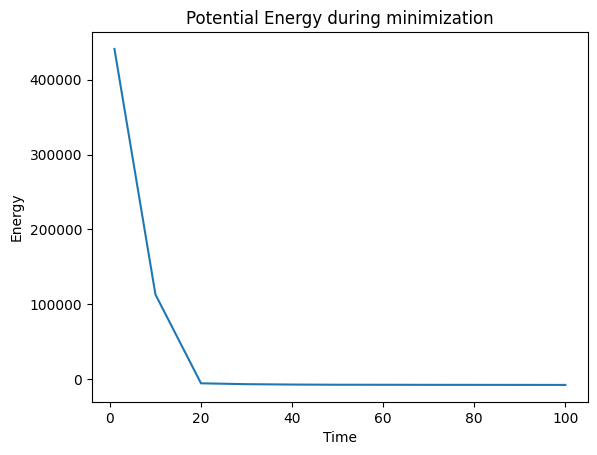

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the file path
file_path = "Tutorial2/min/summary.ENERGY"

# Read the data from the text file
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['Time', 'Energy'])

# Print the DataFrame to check if the data has been loaded correctly
print(data)

# Plot the graph
plt.plot(data['Time'], data['Energy'])
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Potential Energy during minimization')
plt.show()

    Time         RMSD
0      1  60558.00000
1     10  13280.00000
2     20     14.52100
3     30      5.63470
4     40      3.48270
5     50      2.19200
6     60      1.58650
7     70      1.46700
8     80      1.52640
9     90      0.99995
10   100      1.01010


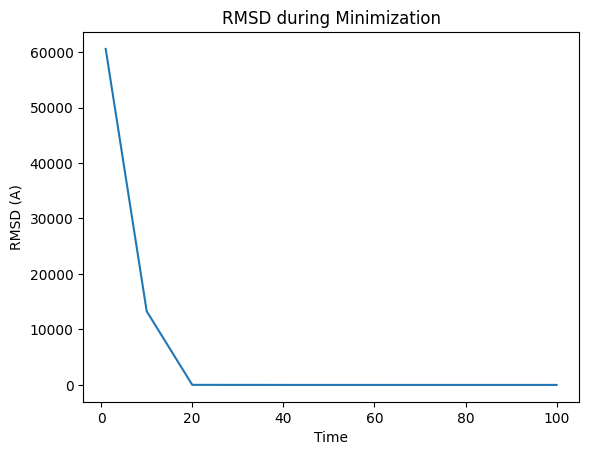

In [6]:
# The RMSD of the system throughout Minimization

# Specify the file path
file_path = "Tutorial2/min/summary.RMS"

# Read the data from the text file
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['Time', 'RMSD'])

# Print the DataFrame to check if the data has been loaded correctly
print(data)

# Plot the graph
plt.plot(data['Time'], data['RMSD'])
plt.xlabel('Time')
plt.ylabel('RMSD (A)')
plt.title('RMSD during Minimization')
plt.show()

In [ ]:
# Make a equ folder

$ process_mdout.perl ../heat.mdout ../md1.mdout

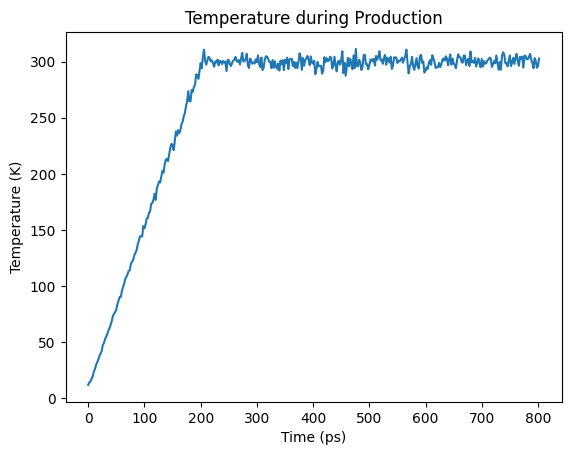

In [10]:
# Temperature of the system throughout production

# Specify the file path
file_path = "Tutorial2/equ/summary.TEMP"

# Read the data from the text file
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'temperature'])

# Plot the graph
plt.plot(data['time'], data['temperature'])
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')
plt.title('Temperature during Production')
plt.show()

      Time     Energy
0      0.0 -7581.3006
1      2.0 -7807.2306
2      4.0 -7805.5542
3      6.0 -7784.6590
4      8.0 -7765.5917
..     ...        ...
397  794.0 -5087.1022
398  796.0 -5152.3425
399  798.0 -5100.2044
400  800.0 -5159.3006
401  802.0 -5180.2048

[402 rows x 2 columns]


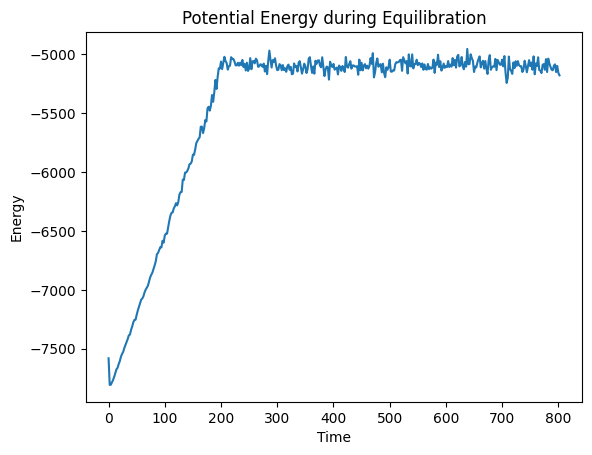

In [12]:
# Graph potential energy of the system throughout equilibration.

# Specify the file path
file_path = "Tutorial2/equ/summary.EPTOT"

# Read the data from the text file
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['Time', 'Energy'])

# Print the DataFrame to check if the data has been loaded correctly
print(data)

# Plot the graph
plt.plot(data['Time'], data['Energy'])
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Potential Energy during Equilibration')
plt.show()

In [ ]:
# Start CPPTRAJ

$ cpptraj

In [ ]:
# Load the topology file

$ parm gfp.parm7

In [ ]:
# Load the trajectory file

$ trajin md1.nc

In [ ]:
# Specify the RMSD command

$ rms first out md1_rms.dat @C,CA,N

In [ ]:
$ run

# output file: md1_rms.dat

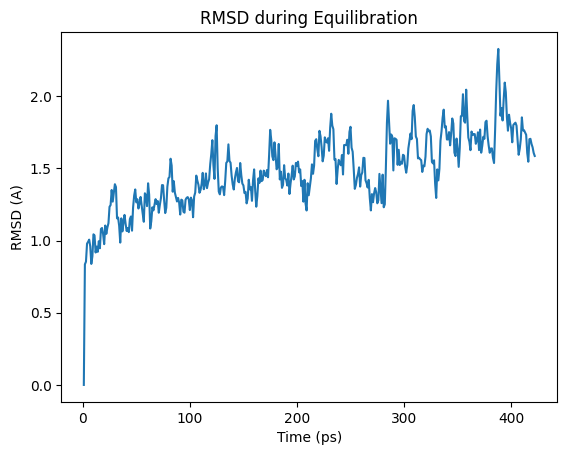

In [3]:
# Graph RMSD of the system throughout equilibration.

# Specify the file path
file_path = "Tutorial2/md1_rms.dat"

# Read the data from the text file
data = pd.read_csv(file_path, delim_whitespace=True)

# Plot the graph
plt.plot(data['#Frame'], data['RMSD_00001'])
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (A)')
plt.title('RMSD during Equilibration')
plt.show()

## CASE STUDY
## Develop force field parameters and coordinate files for the inhibitor JNJ-7706621 (SKE)

#### Part 1: develop force field parameters and coordinate files for the inhibitor JNJ-7706621 (SKE)

In [ ]:
$ module load amber/openmpi/intel/22.03

In [ ]:
$ module load openbabel/intel/3.1.1

In [ ]:
$ wget https://files.rcsb.org/download/5USZ.pdb

In [ ]:
$ grep "HETATM" 5USZ.pdb > jnj.pdb

# Manual delete other elements and only keep SKE

In [ ]:
# Add all the hydrogen atoms to the pdb file

$ reduce jnj.pdb > jnj_h.pdb

In [ ]:
# change the name of the residue from "SKE" to "JNJ"

$ sed 's/SKE/JNJ/g' jnj_h.pdb > jnj_new.pdb

In [ ]:
# -i jnj_new.pdb: input 3D structure file
# -fi: pdb tells antechamber that this is a pdb format file
# -fo mol2: formate of the output file is Tripos Mol2
# -c bcc: tells antechamber to use the AM1-BCC charge model in order to calculate the atomic point charges
# -s 2: option defines the verbosity of the status information provided by antechamber.

$ antechamber -i jnj_new.pdb -fi pdb -o jnj.mol2 -fo mol2 -c bcc -s 2

In [ ]:
# jnj.frcmod is a parameter file that can be loaded into LEaP in order to add missing parameters

$ parmchk2 -i jnj.mol2 -f mol2 -o jnj.frcmod

In [ ]:
# Run tleap

$ tleap -f oldff/leaprc.ff99SB

In [ ]:
# Use GAFF force field

$ source leaprc.gaff

In [ ]:
# load JNJ as a unit in LEaP

$ JNJ = loadmol2 jnj.mol2 

# Loading Mol2 file: ./jnj.mol2
# Reading MOLECULE named JNJ

In [ ]:
$ check JNJ

Checking 'JNJ'....

# Warning: Close contact of 1.490 angstroms between nonbonded atoms HN4A and HN4
# -------  .R<JNJ 1>.A<HN4A 28> and .R<JNJ 1>.A<HN4 30>

# Warning: Close contact of 1.490 angstroms between nonbonded atoms HN1A and HN1
# -------  .R<JNJ 1>.A<HN1A 29> and .R<JNJ 1>.A<HN1 32>
# Checking parameters for unit 'JNJ'.
# Checking for bond parameters.
# Checking for angle parameters.
# check:  Warnings: 2


In [ ]:
# tell tleap the parameters

$ loadamberparams jnj.frcmod

In [ ]:
# create the library file for JNJ

$ saveoff JNJ jnj.lib

In [ ]:
$ saveamberparm JNJ jnj.prmtop jnj.rst7

# Checking Unit.
# Building topology.
# Building atom parameters.
# Building bond parameters.
# Building angle parameters.
# Building proper torsion parameters.
# Building improper torsion parameters.
#  total 18 improper torsions applied
# Building H-Bond parameters.
# Incorporating Non-Bonded adjustments.
# Not Marking per-residue atom chain types.
# Marking per-residue atom chain types.
#   (Residues lacking connect0/connect1 - 
#    these don't have chain types marked:

#         res     total affected

#         JNJ     1
#   )
#  (no restraints)

In [ ]:
$ quit

#### Part 2: minimize and equilibrate the JAK2-SKE complex with a GB model (IGB=8)

In [ ]:
# Protein: ff99SB force field
# Molecule: GAFF force field

In [ ]:
$ sed 's/SKE/JNJ/g' 5USZ.pdb > 5usz_jnj_init.pdb
# Manually delete unrelatived HETATM from the pdb

In [ ]:
$ tleap -f oldff/leaprc.ff99SB

In [ ]:
$ source leaprc.gaff 

# ----- Source: /ext3/apps/amber/22.03/openmpi/intel/dat/leap/cmd/leaprc.gaff
# ----- Source of /ext3/apps/amber/22.03/openmpi/intel/dat/leap/cmd/leaprc.gaff done
# Log file: ./leap.log
# Loading parameters: /ext3/apps/amber/22.03/openmpi/intel/dat/leap/parm/gaff.dat
# Reading title:
# AMBER General Force Field for organic molecules (Version 1.81, May 2017)

In [ ]:
$ loadamberparams jnj.frcmod

# Loading parameters: ./jnj.frcmod
# Reading force field modification type file (frcmod)
# Reading title:
# Remark line goes here

In [ ]:
$ loadoff jnj.lib

# Loading library: ./jnj.lib

In [ ]:
$ complex = loadpdb 5usz_jnj.pdb

# Loading PDB file: ./5usz_jnj.pdb
# -- residue 561: duplicate [ CA] atoms (total 2)
# -- residue 561: duplicate [ CB] atoms (total 2)
# -- residue 561: duplicate [ CD] atoms (total 2)
# -- residue 561: duplicate [ CE] atoms (total 2)
# -- residue 561: duplicate [ CG] atoms (total 2)
# -- residue 561: duplicate [ NZ] atoms (total 2)

# Warning: Atom names in each residue should be unique.
#      (Same-name atoms are handled by using the first
#       occurrence and by ignoring the rest.
#       Many instances of duplicate atom names usually come
#       from alternate conformations in the PDB file.)

#   Added missing heavy atom: .R<ARG 541>.A<CG 8>
#   Added missing heavy atom: .R<ARG 541>.A<CD 11>
#   Added missing heavy atom: .R<ARG 541>.A<NE 14>
#   Added missing heavy atom: .R<ARG 541>.A<CZ 16>
#   Added missing heavy atom: .R<ARG 541>.A<NH1 17>
#   Added missing heavy atom: .R<ARG 541>.A<NH2 20>

In [ ]:
$ set default PBradii bondi

In [ ]:
$ saveamberparm complex 5usz_jnj.prmtop 5usz_jnj.rst7

# Checking Unit.

# Warning: The unperturbed charge of the unit (-2.000000) is not zero.

# Note: Ignoring the warning from Unit Checking.

# Building topology.
# Building atom parameters.
# Building bond parameters.
# Building angle parameters.
# Building proper torsion parameters.
# Building improper torsion parameters.
#  total 877 improper torsions applied
# Building H-Bond parameters.
# Incorporating Non-Bonded adjustments.
# Not Marking per-residue atom chain types.
# Marking per-residue atom chain types.
#   (Residues lacking connect0/connect1 - 
#    these don't have chain types marked:

#         res     total affected

#         CLEU    1
#         JNJ     1
#         NPHE    1
#   )
#  (no restraints)

In [ ]:
$ savepdb complex 5usz_jnj.pdb

#### Minimize and Equilibrate the complex

In [ ]:
# Make a min.in file

    """
  simple generalized Born minimization script
 &cntrl
   imin=1, ntb=0, maxcyc=100, ntpr=10, cut=1000., igb=8, 
 /
    """

In [ ]:
# Make heat.in file

    """
Implicit solvent initial heating mdin
 &cntrl
   imin=0, irest=0, ntx=1,
   ntpr=1000, ntwx=1000, nstlim=100000,
   dt=0.002, ntt=3, tempi=10,
   temp0=300, gamma_ln=1.0, ig=-1,
   ntp=0, ntc=2, ntf=2, cut=1000,
   ntb=0, igb=8, ioutfm=1, nmropt=1,
 /
 &wt
   TYPE='TEMP0', ISTEP1=1, ISTEP2=100000,
   VALUE1=10.0, VALUE2=300.0,
 /
 &wt TYPE='END' /
    """

In [ ]:
# Make eq.in file

    """
Initial MD equilibration
 &cntrl
  imin=0, irest=0,
  nstlim=50000,dt=0.001, ntc=1,
  ntpr=20, ntwx=20,
  cut=16, ntb=0, igb=1,
  ntt=3, gamma_ln=1.0,
  tempi=0.0, temp0=300.0,
 &end
    """

In [ ]:
# Make a amberjob1.sbatch file

    """
#!/bin/bash

#SBATCH --job-name=Amber
#SBATCH --nodes=1
#SBATCH --tasks-per-node=20
#SBATCH --time=48:00:00
#SBATCH --mem=20GB
unset SLURM_TRES_PER_TASK

# Comments start here, above are not comments and should be in your script 
# go to your working directory: /scratch/qo210/comp-lab-class-2024/Week7/JNJ  
cd /scratch/qo210/comp-lab-class-2024/Week7/JNJ

# load module to run amber

module purge
module load amber/openmpi/intel/20.11 

# run minimization job
sander -O -i min.in -o 5usz_jnj_min.out -p 5usz_jnj.prmtop -c 5usz_jnj.rst7 -r 5usz_jnj_min.rst7

# run heating job
sander -O -i heat.in -o 5usz_jnj_heat.mdout -p 5usz_jnj.prmtop -c 5usz_jnj_min.rst7 -r 5usz_jnj_heat.rst7 -x heat.nc

# run md job
sander -O -i eq.in -o 5usz_jnj_eq.out -p 5usz_jnj.prmtop -c 5usz_jnj_heat.rst7  -r 5usz_jnj_eq.rst7 -x 5usz_jnj_eq.nc
    """

In [ ]:
$ sbatch amberjob1.sbatch

### Part 3: Analysis

In [ ]:
# Make a min folder
$ process_minout.perl ../5usz_jnj_min.out

    Time   Energy
0      1  -7566.6
1     10  -8755.4
2     20  -9835.9
3     30  -9982.4
4     40 -10191.0
5     50 -10355.0
6     60 -10382.0
7     70 -10442.0
8     80 -10463.0
9     90 -10497.0
10   100 -10518.0


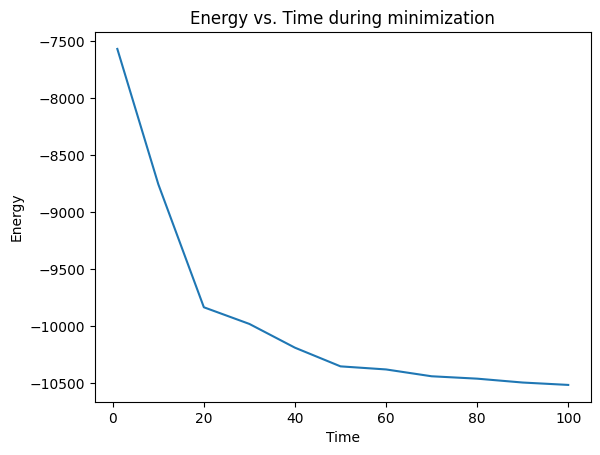

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the file path
file_path = "JNJ/min/summary.ENERGY"

# Read the data from the text file
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['Time', 'Energy'])

# Print the DataFrame to check if the data has been loaded correctly
print(data)

# Plot the graph
plt.plot(data['Time'], data['Energy'])
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs. Time during minimization')
plt.show()

    time        rms
0      1  112.83000
1     10   16.98900
2     20    3.44790
3     30    2.92370
4     40    2.62620
5     50    1.66700
6     60    1.15700
7     70    1.61600
8     80    1.00280
9     90    0.59713
10   100    0.76430


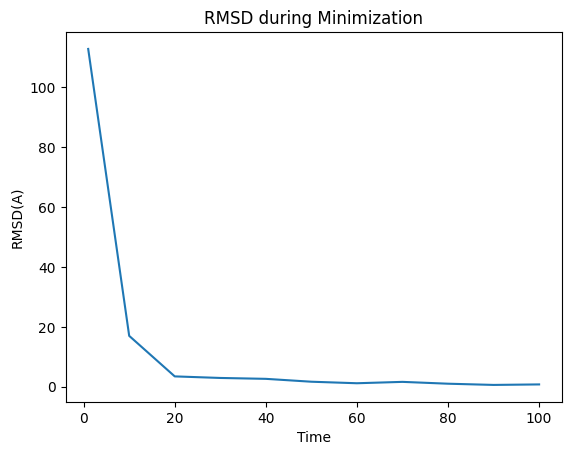

In [7]:
# Specify the file path
file_path = "JNJ/min/summary.RMS"

# Read the data from the text file
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'rms'])

# Print the DataFrame to check if the data has been loaded correctly
print(data)

# Plot the graph
plt.plot(data['time'], data['rms'])
plt.xlabel('Time')
plt.ylabel('RMSD(A)')
plt.title('RMSD during Minimization')
plt.show()

In [ ]:
# Make an analysis folder

$ process_mdout.perl ../5usz_jnj_heat.mdout ../5usz_jnj_eq.out


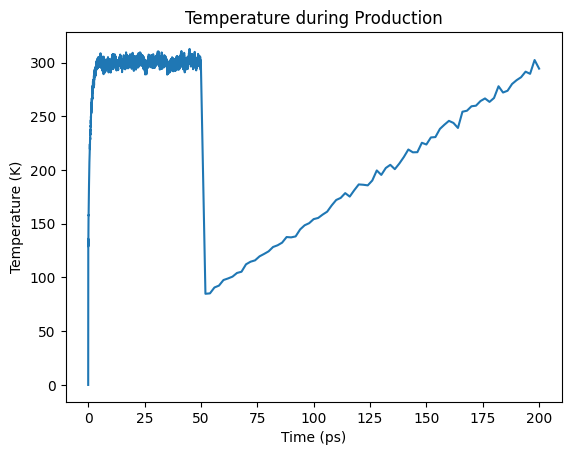

In [8]:
# Temperature of the system throughout production

# Specify the file path
file_path = "JNJ/analysis/summary.TEMP"

# Read the data from the text file
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'temperature'])

# Plot the graph
plt.plot(data['time'], data['temperature'])
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')
plt.title('Temperature during Production')
plt.show()

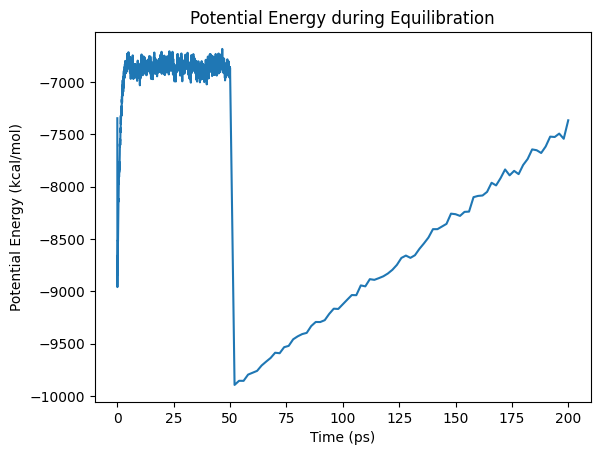

In [9]:
# Graph potential energy of the system throughout equilibration.

# Specify the file path
file_path = "JNJ/analysis/summary.EPTOT"

# Read the data from the text file
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'potential_energy'])


# Plot the graph
plt.plot(data['time'], data['potential_energy'])
plt.xlabel('Time (ps)')
plt.ylabel('Potential Energy (kcal/mol)')
plt.title('Potential Energy during Equilibration')
plt.show()

In [ ]:
# Use cpptraj to calculate root mean square deviation (RMSD) for us as a function of time
# start CPPTRAJ
$ CPPTRAJ

In [ ]:
# Load the topology (using the parm command)
$ parm 5usz_jnj.prmtop

In [ ]:
# Load trajectory file (using the trajin command)
$ trajin 5usz_jnj_eq.nc

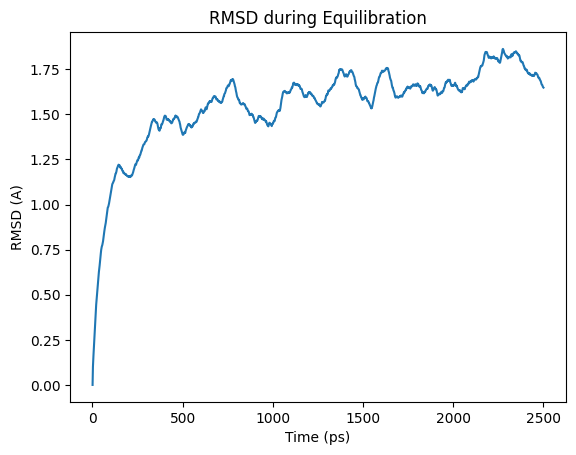

In [16]:
# Graph RMSD of the system throughout equilibration.

# Specify the file path
file_path = "JNJ/md1_rms.dat"

# Read the data from the text file
data = pd.read_csv(file_path, delim_whitespace=True)

# Plot the graph
plt.plot(data['#Frame'], data['RMSD_00001'])
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (A)')
plt.title('RMSD during Equilibration')
plt.show()